<a href="https://colab.research.google.com/github/TonmoyTalukder/Img2Cap/blob/main/Im2Cap_Image_captioning_using_LM_T5_or_VitGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

### Installs and Imports

In [ ]:
%%capture
!pip3 install transformers
!pip3 install sentencepiece
!pip3 install timm

from transformers import ViltProcessor, ViltForMaskedLM, DetrFeatureExtractor, DetrForObjectDetection, AutoModelWithLMHead, AutoTokenizer
import requests
from PIL import Image
import re
import torch
import torchvision

import spacy

import numpy as np
import pandas as pd
import random

from transformers import PegasusForConditionalGeneration, PegasusTokenizer


# from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer


In [ ]:
# %%capture
# !pip install --upgrade pip
# !pip install --no-cache-dir transformers sentencepiece
# !pip install pytorch_lightning

### Models

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Resnet 50 by Facebook
feature_extractor0 = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
device0 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model0 = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device0)
# model0 = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")


processor1 = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-coco")
device1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = ViltForMaskedLM.from_pretrained("dandelin/vilt-b32-finetuned-coco").to(device1)


model2name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model2name)
model3 = PegasusForConditionalGeneration.from_pretrained(model2name).to(torch_device)


device4 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device4)
processor2 = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Trained T5
t5tokenizer = AutoTokenizer.from_pretrained("t5-base")
t5model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-common_gen")

# GPT Model
model_gpt = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor_gpt = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer_gpt = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

### Necessary Functions

In [ ]:
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(requests.get(image_path, stream=True).raw).convert('RGB')
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor_gpt(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model_gpt.generate(pixel_values, **gen_kwargs)

  preds = tokenizer_gpt.batch_decode(output_ids, skip_special_tokens=True)

  preds = [pred.strip() for pred in preds]
  return preds[0]

In [ ]:
def get_object_phrase(doc):
  for token in doc:
    if (token.dep_ in objList):
      subtree = list(token.subtree)
      start = subtree[0].i
      end = subtree[-1].i + 1
      return doc[start:end]

In [ ]:
def get_response(input_text,num_return_sequences,num_beams):
    batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
    translated = model3.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    return tgt_text

In [ ]:
def getMaskedSentences(detectedObj):
    maskedSentences = []

    for i1, id1 in enumerate(objects):
      for j, id2 in enumerate(objects):
        if(id1 != id2):
          k = id1 + " [MASK] " + id2
          maskedSentences.append(k)
    return maskedSentences

In [ ]:
def trainedt5model(words, max_length=32):
  words = " ".join(words)
  input_text = words
  features = t5tokenizer([input_text], return_tensors='pt')
  output = t5model.generate(input_ids=features['input_ids'],
               attention_mask=features['attention_mask'],
               max_length=max_length)

  return t5tokenizer.decode(output[0], skip_special_tokens=True)

# Caption Generate from Image

In [21]:
image_path = 'https://www.wehorse.com/en/blog/wp-content/uploads/2022/01/Adults-learn-to-ride-scaled.jpg'
image = Image.open(requests.get(image_path, stream=True).raw).convert('RGB')
emptyList = []

## ----------- Object Detection ----------- ##

inputs = feature_extractor0(images=image, return_tensors="pt").to(device0)
outputs = model0(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = feature_extractor0.post_process(outputs, target_sizes=target_sizes)[0]


objects = []
for score, label in zip(results["scores"],results["labels"]):
    if(score > 0.95):
        objects.append(str(model0.config.id2label[label.item()]))

objects = np.unique(objects)

## -------------- Detected Object Count Preprocess -------------- ##

objSize = objects.size
flagObj = 0

if objSize < 2:
    flagObj = 1
elif objSize == 2:
    if str(objects[0]) == 'N/A':
        flagObj = 1
    elif str(objects[1]) == 'N/A':
        flagObj = 1

if flagObj == 0:

    sentenceList1 = getMaskedSentences(objects)

    emptyList.append(objects)

    ## ----------- Detected words to mask ----------- ##

    sentenceList2 = []

    for i2 in enumerate(sentenceList1):
        # text = "person [MASK] ."          ## Need to do all possible masking with the detected objects
        # text = "person [MASK] horse."          ## Need to do all possible masking with the detected objects
        text = i2[1]

        # prepare inputs
        encoding = processor1(image, text, return_tensors="pt").to(device1)

        # forward pass
        outputs = model1(**encoding)

        tl = len(re.findall("\[MASK\]", text))
        inferred_token = [text]

        # gradually fill in the MASK tokens, one by one
        with torch.no_grad():
            for i3 in range(tl):
                encoded = processor1.tokenizer(inferred_token)
                input_ids = torch.tensor(encoded.input_ids)
                encoded = encoded["input_ids"][0][1:-1]
                mlm_logits = outputs.logits[0]  # shape (seq_len, vocab_size)
                # only take into account text features (minus CLS and SEP token)
                mlm_logits = mlm_logits[1 : input_ids.shape[1] - 1, :]
                mlm_values, mlm_ids = mlm_logits.softmax(dim=-1).max(dim=-1)
                # only take into account text
                mlm_values[torch.tensor(encoded) != 103] = 0
                select = mlm_values.argmax().item()
                encoded[select] = mlm_ids[select].item()
                inferred_token = [processor1.decode(encoded)]

        selected_token = ""
        encoded = processor1.tokenizer(inferred_token)
        output = processor1.decode(encoded.input_ids[0], skip_special_tokens=True)
        sentenceList2.append(output)

    emptyList.append(sentenceList2)


    ## ----------- Remove if the subject starts with Object ----------- ##

    nlp1 = spacy.load('en_core_web_sm')

    sentences= sentenceList2

    objList = ["dobj", "obj", "iobj"]

    for sentence in sentences:
        doc = nlp1(sentence)
        object_phrase = get_object_phrase(doc)
        if(str(object_phrase) == str(sentence.split()[0])):
            print(sentence)
            sentenceList2.remove(sentence)

    random.shuffle(sentenceList2)
    random.shuffle(sentenceList2)

    emptyList.append(sentenceList2)

    cleanedKeywords = emptyList[2]

    ## ----------- Gen Sentence with T5 ----------- ##

    genCapT5 = trainedt5model(cleanedKeywords)

    ## ----------- Pharaphrase ----------- ##

    num_beams = 10
    num_return_sequences = 10
    # context = "A person riding a horse."     ## We can paste here the T5 generated sentence
    context = genCapT5    ## We can paste here the T5 generated sentence
    paraphrasedSentences = get_response(context,num_return_sequences,num_beams)


    ## ----------- Clip Model ----------- ##

    inputs = processor2(text=paraphrasedSentences, images=image, return_tensors="pt", padding=True).to(device4)

    outputs = model4(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    # probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

    max = 0
    k = 0
    for i4, id4 in enumerate(logits_per_image[0]):
        if(max < id4):
            max = id4
            k = i4
    print(paraphrasedSentences[k])

# GPT
elif flagObj == 1:
    # continue
    genCapGPT = predict_step([image_path])
    flagObj = 0
    print(genCapGPT)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


The person and horse are in a mission.


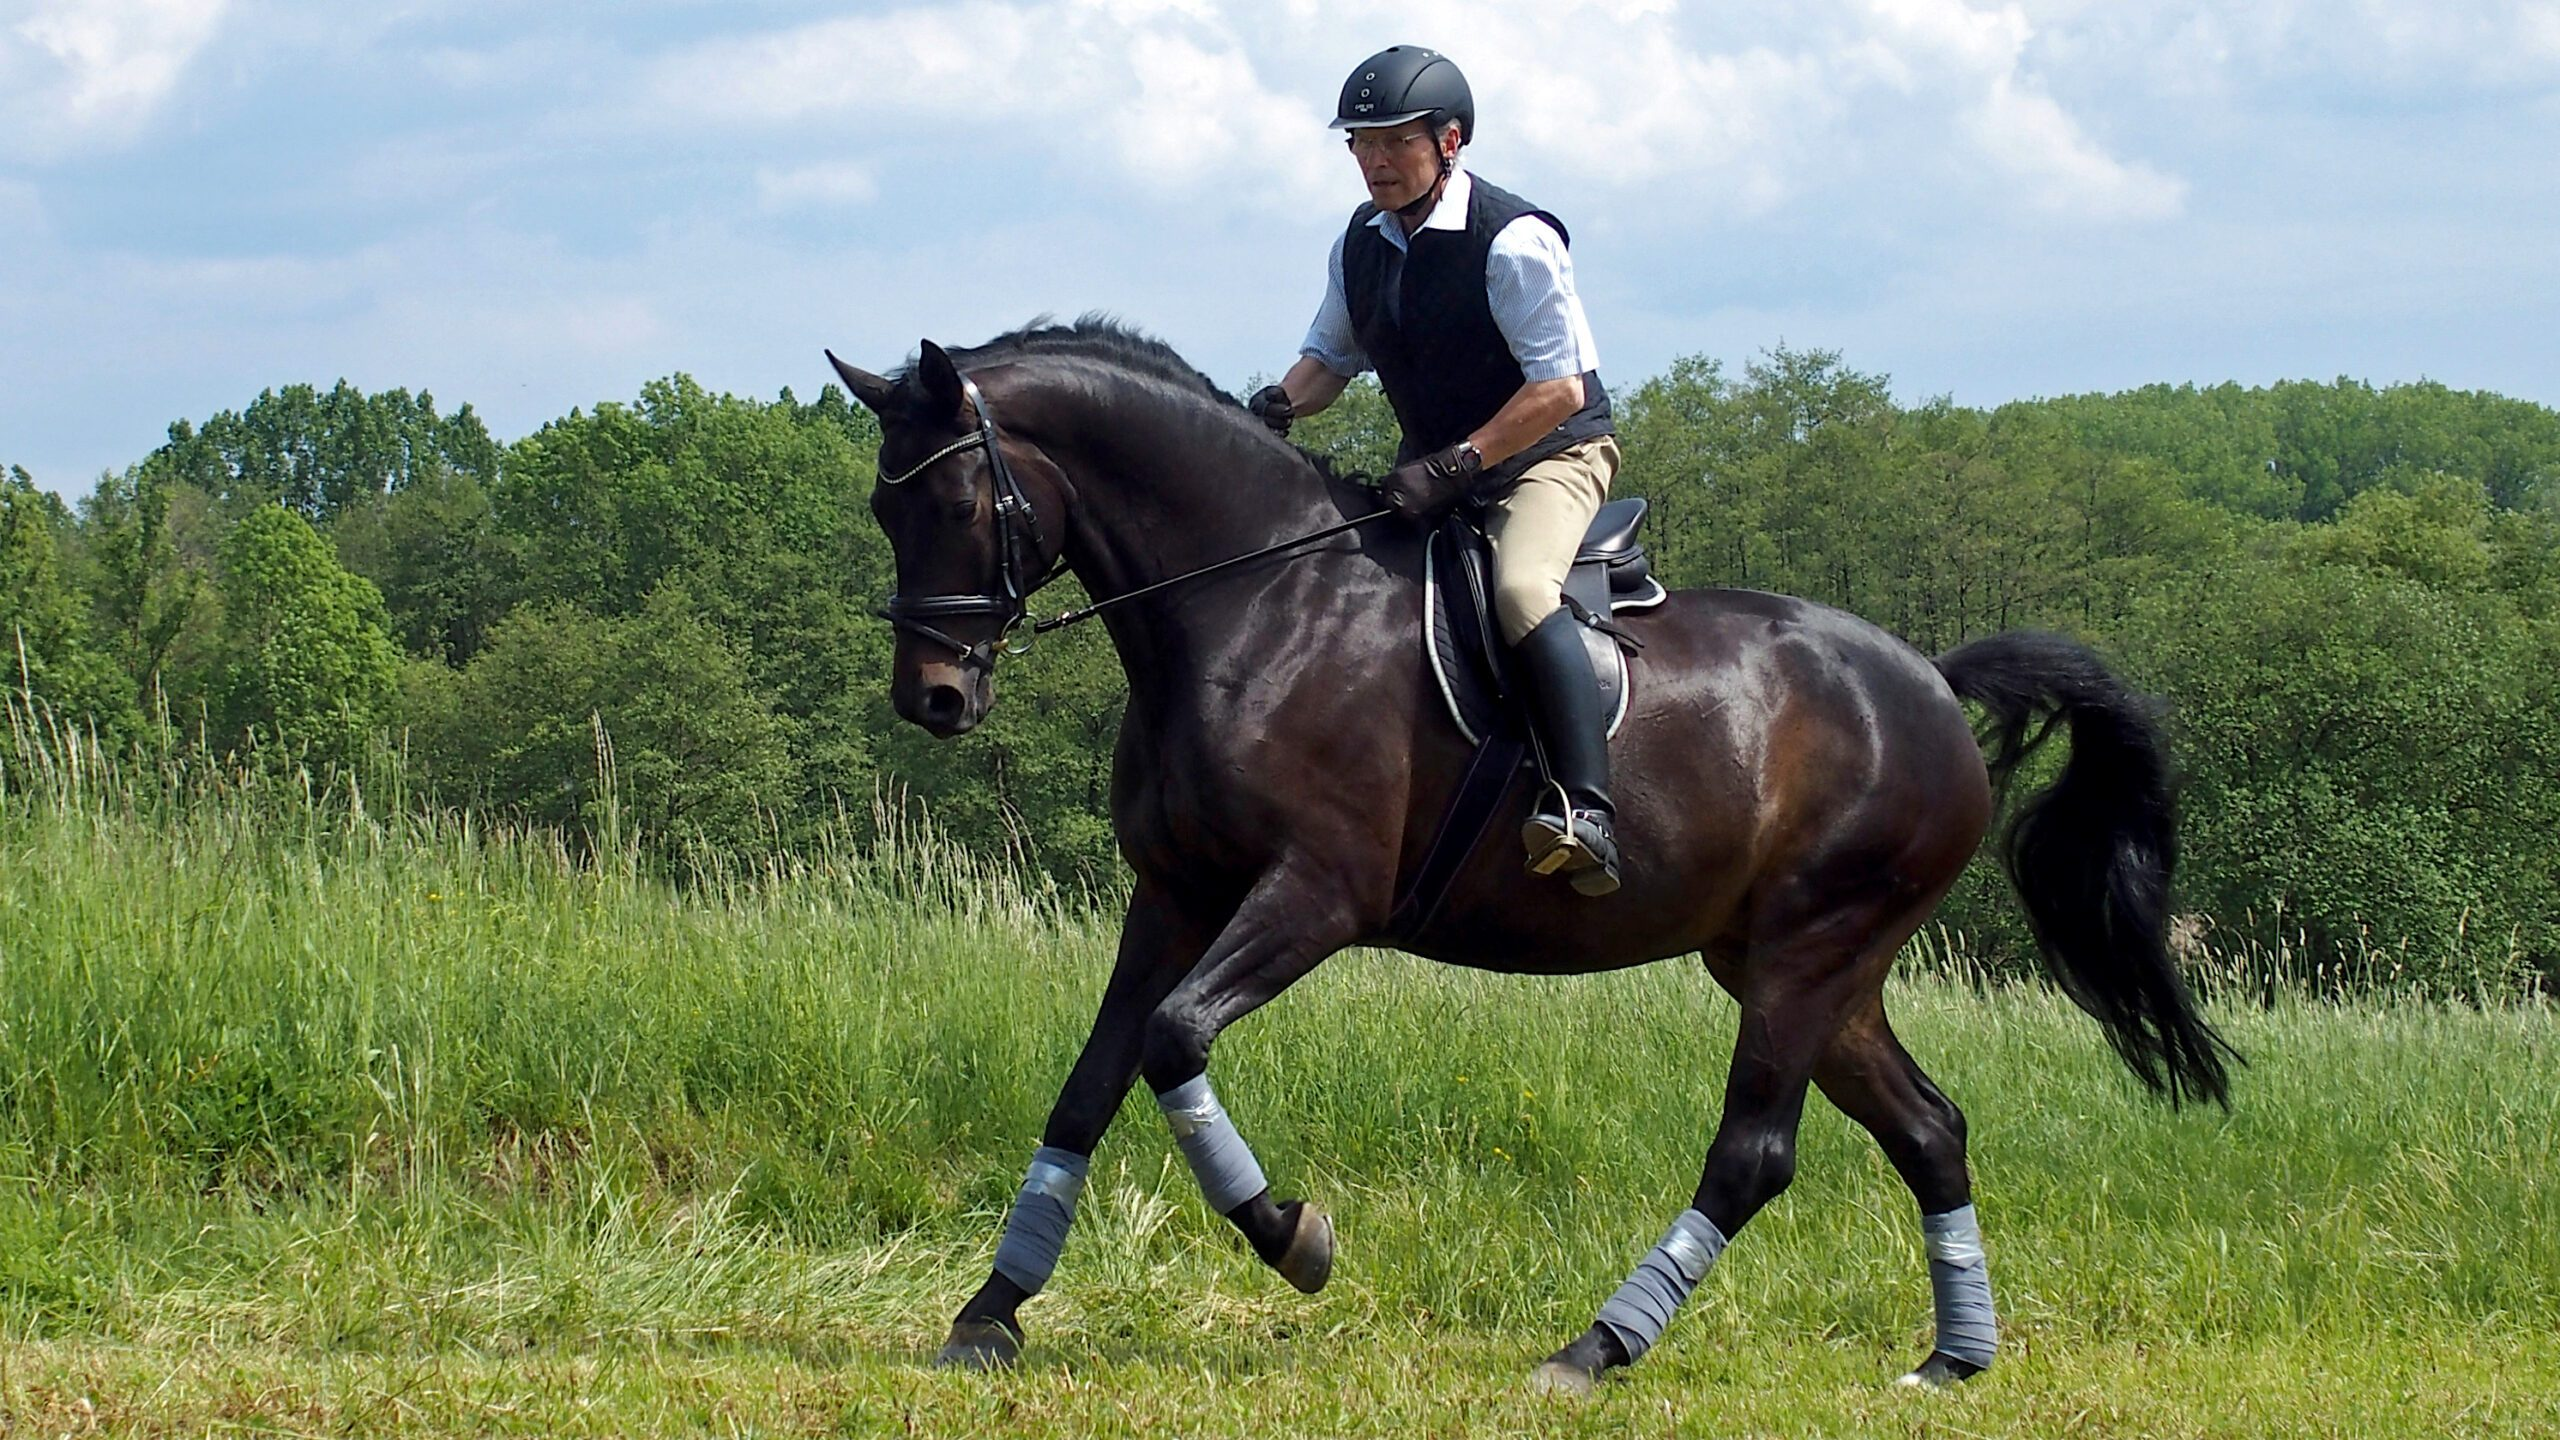

In [22]:
image